### Imports

In [25]:
# Libraries
import os
from importlib import reload

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scripts
from acml import data, runners, utils

In [26]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [27]:
!pip show keras

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [28]:
reload(runners)
reload(data)
reload(utils)

<module 'acml.utils' from 'c:\\Users\\sonar\\Desktop\\acml_2024_s2\\runner\\acml\\utils.py'>

In [29]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 


GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

In [30]:
INPUT_SIZE=(128, 128)
BATCH_SIZE = 4

### Load data

In [31]:
fold_definitions = pd.read_csv("data/deepship_5k_seg_3s.csv")

### JUST SELECT 4 FOLDS
fold_definitions = fold_definitions[fold_definitions["folds"].isin(range(4))]

fold_definitions.head()

,files,labels,folds
3,/home/thales/src/ajaac/datasets/DeepShip/DeepS...,3,0
5,/home/thales/src/ajaac/datasets/DeepShip/DeepS...,3,2
6,/home/thales/src/ajaac/datasets/DeepShip/DeepS...,3,1
8,/home/thales/src/ajaac/datasets/DeepShip/DeepS...,3,0
9,/home/thales/src/ajaac/datasets/DeepShip/DeepS...,3,3


In [32]:
fold_definitions = data._rename_folds(
    fold_definitions, 
    new_path_to_root="data/deepship_ps_2_npz",
    unix=False,
    npz=True
)

fold_definitions.loc[:, 'spectrogram'] = fold_definitions["files"].apply(
    lambda x: np.load(x)['np_data']
)

fold_definitions.head()

,files,labels,folds,spectrogram
3,data\deepship_ps_2_npz\Passengership\V2V_EMPRE...,3,0,"[[-7.4327559925061, -15.4233283408313, -10.787..."
5,data\deepship_ps_2_npz\Passengership\SPIRIT_OF...,3,2,"[[-17.6338969029006, -6.90289448113819, -2.070..."
6,data\deepship_ps_2_npz\Passengership\SAFARI_EX...,3,1,"[[-25.785495348337, -13.3206570461283, -14.665..."
8,data\deepship_ps_2_npz\Passengership\SALISH_OR...,3,0,"[[0.984354381694922, 2.00003731088616, 4.05349..."
9,data\deepship_ps_2_npz\Passengership\SPIRIT_OF...,3,3,"[[17.3807324439104, 18.3480862575462, 17.15245..."


In [33]:
folds = fold_definitions["folds"].to_numpy(copy=True)

# 1D
X_train = fold_definitions["spectrogram"].to_numpy(copy=True)

del fold_definitions

# 3D
X_train = np.stack(X_train)

# Add convolution dimension
X_train = np.expand_dims(X_train, axis=-1)

# Resize to square input
X_train = tf.image.resize(X_train, INPUT_SIZE).numpy()

In [34]:
# Normalise all spectrograms
X_train_min = X_train.min()
X_train_max = X_train.max()

print(f"X_train_min: {X_train_min}")
print(f"X_train_max: {X_train_max}")

# Save one spectrogram
pre = X_train[99]

X_train = (X_train - X_train_min) / (X_train_max - X_train_min)

post = X_train[99]

print(f"X_train_min: {X_train.min()}")
print(f"X_train_max: {X_train.max()}")

X_train_min: -74.09904479980469
X_train_max: 35.86322021484375
X_train_min: 0.0
X_train_max: 1.0


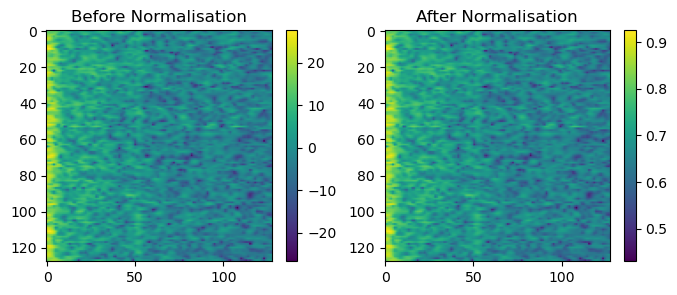

In [35]:
plt.figure(figsize=(8, 3))

# INPUT
plt.subplot(1, 2, 1)
plt.imshow(pre.squeeze(), cmap="viridis", aspect="auto")
plt.title("Before Normalisation")
plt.colorbar()

# DENOISED OUTPUT
plt.subplot(1, 2, 2)
plt.imshow(post.squeeze(), cmap="viridis", aspect="auto")
plt.title("After Normalisation")
plt.colorbar()

In [36]:
# Get testing split
X_train, X_test = train_test_split(
    X_train,
    test_size=0.2,
    random_state=100,
    shuffle=True
)

print("Final input shape:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

Final input shape:
X_train: (18479, 128, 128, 1)
X_test: (4620, 128, 128, 1)


### Initialise model

In [37]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [38]:
# Learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000, 
    decay_rate=0.9 
)

In [39]:
from models import irfan_2020_modified 
reload(irfan_2020_modified)

irfan = irfan_2020_modified.get_compiled_model_128() 

In [40]:
# Train the model

history = irfan.fit(
    x=X_train,
    y=X_train,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_split=0.1,
    shuffle=True,
    verbose=2
)

Epoch 1/10
4158/4158 - 51s - loss: 0.1051 - mae: 0.1552 - val_loss: 0.0012 - val_mae: 0.0268 - 51s/epoch - 12ms/step
Epoch 2/10
4158/4158 - 49s - loss: 0.0015 - mae: 0.0302 - val_loss: 0.0011 - val_mae: 0.0247 - 49s/epoch - 12ms/step
Epoch 3/10
4158/4158 - 49s - loss: 0.0013 - mae: 0.0287 - val_loss: 0.0406 - val_mae: 0.1518 - 49s/epoch - 12ms/step
Epoch 4/10
4158/4158 - 49s - loss: 0.0012 - mae: 0.0275 - val_loss: 7.5164e-04 - val_mae: 0.0213 - 49s/epoch - 12ms/step
Epoch 5/10
4158/4158 - 49s - loss: 0.0012 - mae: 0.0274 - val_loss: 7.6269e-04 - val_mae: 0.0210 - 49s/epoch - 12ms/step
Epoch 6/10
4158/4158 - 49s - loss: 0.0012 - mae: 0.0267 - val_loss: 7.0214e-04 - val_mae: 0.0202 - 49s/epoch - 12ms/step
Epoch 7/10
4158/4158 - 49s - loss: 0.0012 - mae: 0.0270 - val_loss: 7.0376e-04 - val_mae: 0.0205 - 49s/epoch - 12ms/step
Epoch 8/10
4158/4158 - 49s - loss: 0.0011 - mae: 0.0265 - val_loss: 6.6966e-04 - val_mae: 0.0200 - 49s/epoch - 12ms/step
Epoch 9/10
4158/4158 - 49s - loss: 0.0011 - 

In [41]:
evals = irfan.evaluate(
    x=X_test,
    y=X_test,
    batch_size=BATCH_SIZE,
    verbose=2
)

1155/1155 - 5s - loss: 6.4482e-04 - mae: 0.0195 - 5s/epoch - 4ms/step


In [59]:
irfan.save("models/irfan_denoise.keras")

### Evaluation, metrics, and visualising denoised output

In [54]:
num_samples = 5  
sample_indices = np.random.choice(range(X_test.shape[0]), num_samples, replace=False)
sample_inputs = X_test[sample_indices]

# Predict the denoised outputs
denoised_outputs = irfan.predict(sample_inputs)

1/1 [==============================] - 0s 24ms/step


In [55]:
# Get evaluation metrics
mse_score = tf.keras.losses.MeanSquaredError()(sample_inputs, denoised_outputs).numpy()
psnr_score = psnr(sample_inputs, denoised_outputs).numpy()

print(f"MSE: {mse_score}")
print(f"PSNR: {psnr_score}")

MSE: 0.0006374813383445144
PSNR: [31.94335  31.85091  32.12532  31.884035 31.978214]


In [56]:
# Check if all outputs are normalised

for output in denoised_outputs:
    print(f"Min: {np.min(output)}; Max: {np.max(output)}")

Min: 0.3872658610343933; Max: 0.8045300841331482
Min: 0.409837007522583; Max: 0.8259720802307129
Min: 0.4728218615055084; Max: 0.794709324836731
Min: 0.4114173650741577; Max: 0.8334389925003052
Min: 0.3917199671268463; Max: 0.7287189364433289


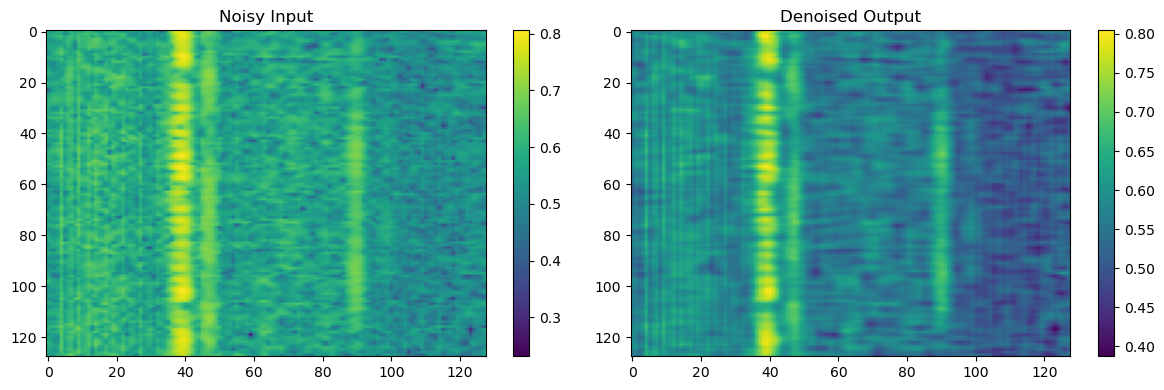

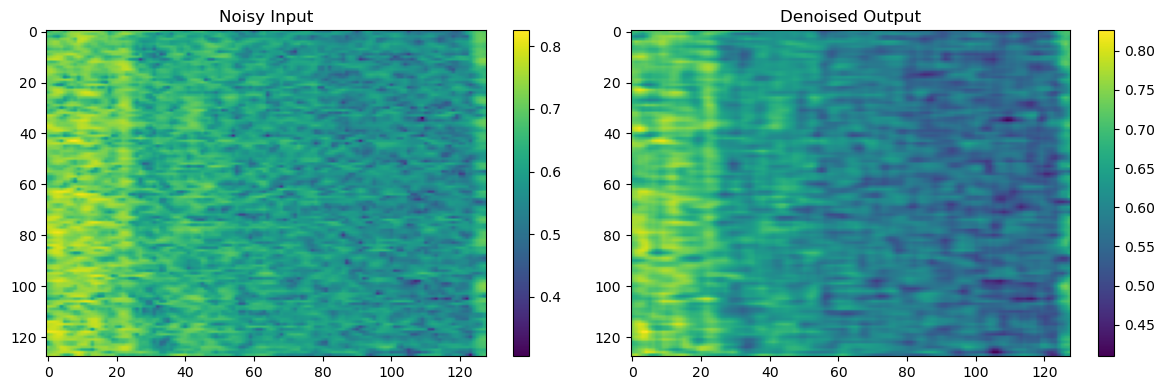

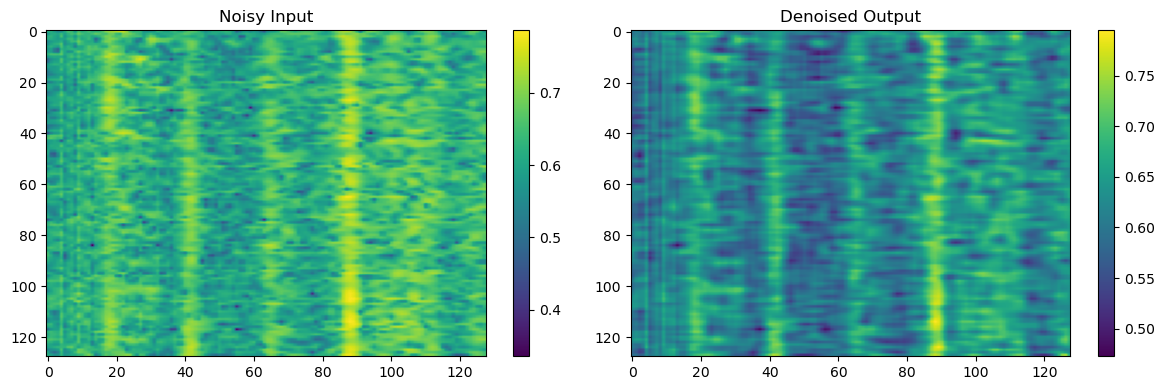

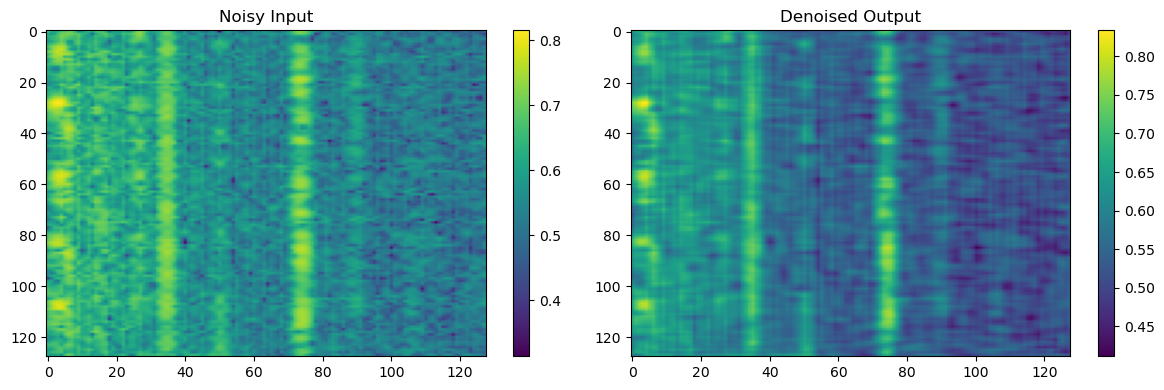

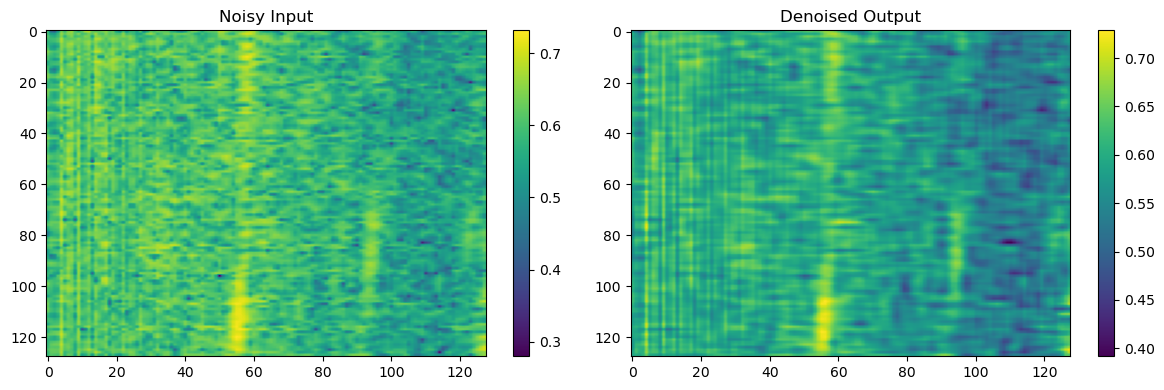

In [58]:
# Plot the input, output, and target spectrograms for each sample
for i in range(num_samples):
    fig = plt.figure(figsize=(12, 4))
    
    # INPUT
    plt.subplot(1, 2, 1)
    plt.imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Noisy Input")
    plt.colorbar()

    # DENOISED OUTPUT
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Denoised Output")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    fig.savefig(f"models/img/irfan_denoise/ex{i + 1}.png")